In [2]:
!pip install cellpose
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from google.colab import files
import tifffile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of Fluo-N2DL-HeLa folder:
  - t000.tif
  - t001.tif
  - t002.tif
  - t003.tif
  - t004.tif
  - t005.tif
  - t006.tif
  - t007.tif
  - t008.tif
  - t009.tif
  - t010.tif
  - t011.tif
  - t012.tif
  - t013.tif
  - t014.tif
  - t015.tif
  - t016.tif
  - t017.tif
  - t018.tif
  - t019.tif
  - t020.tif
  - t021.tif
  - t022.tif
  - t023.tif
  - t024.tif
  - t025.tif
  - t026.tif
  - t027.tif
  - t028.tif
  - t029.tif
Found 30 frames in the sequence
First file: t000.tif
Last file: t029.tif

Sequence shape: (30, 1024, 1024)
Data type: uint8


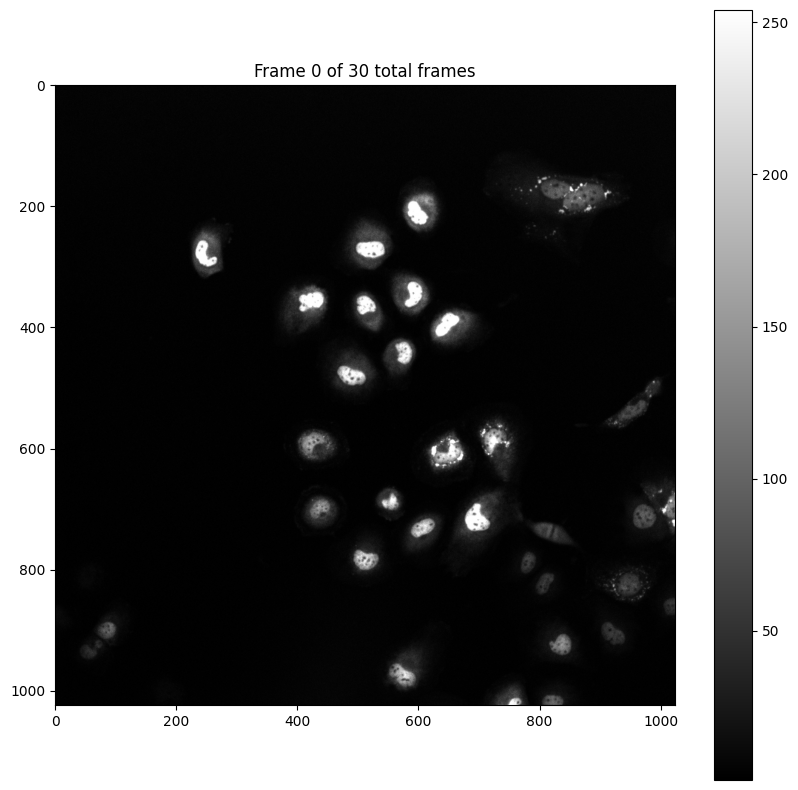

In [7]:
from google.colab import drive
import os
drive.mount('/content/drive')


dataset_path = '/content/drive/MyDrive/01'

contents = os.listdir(dataset_path)
print("Contents of Fluo-N2DL-HeLa folder:")
for item in sorted(contents):
    print(f"  - {item}")

import os
import glob

sequence_path = '/content/drive/MyDrive/01'

image_files = sorted(glob.glob(os.path.join(sequence_path, '*.tif')))

print(f"Found {len(image_files)} frames in the sequence")
print(f"First file: {os.path.basename(image_files[0])}")
print(f"Last file: {os.path.basename(image_files[-1])}")

# Load all frames
frames = []
for img_file in image_files:
    frame = tifffile.imread(img_file)
    frames.append(frame)

# Convert to numpy array
frames = np.array(frames)
print(f"\nSequence shape: {frames.shape}")
print(f"Data type: {frames.dtype}")

# Display the first frame
plt.figure(figsize=(10, 10))
plt.imshow(frames[0], cmap='gray')
plt.title(f'Frame 0 of {len(frames)} total frames')
plt.colorbar()
plt.show()

Initializing Cellpose CNN model...


Segmenting 30 frames with Cellpose CNN...
Processing frame 0/30...


Processing frame 10/30...


Processing frame 20/30...



Segmentation complete!
Masks shape: (30, 1024, 1024)


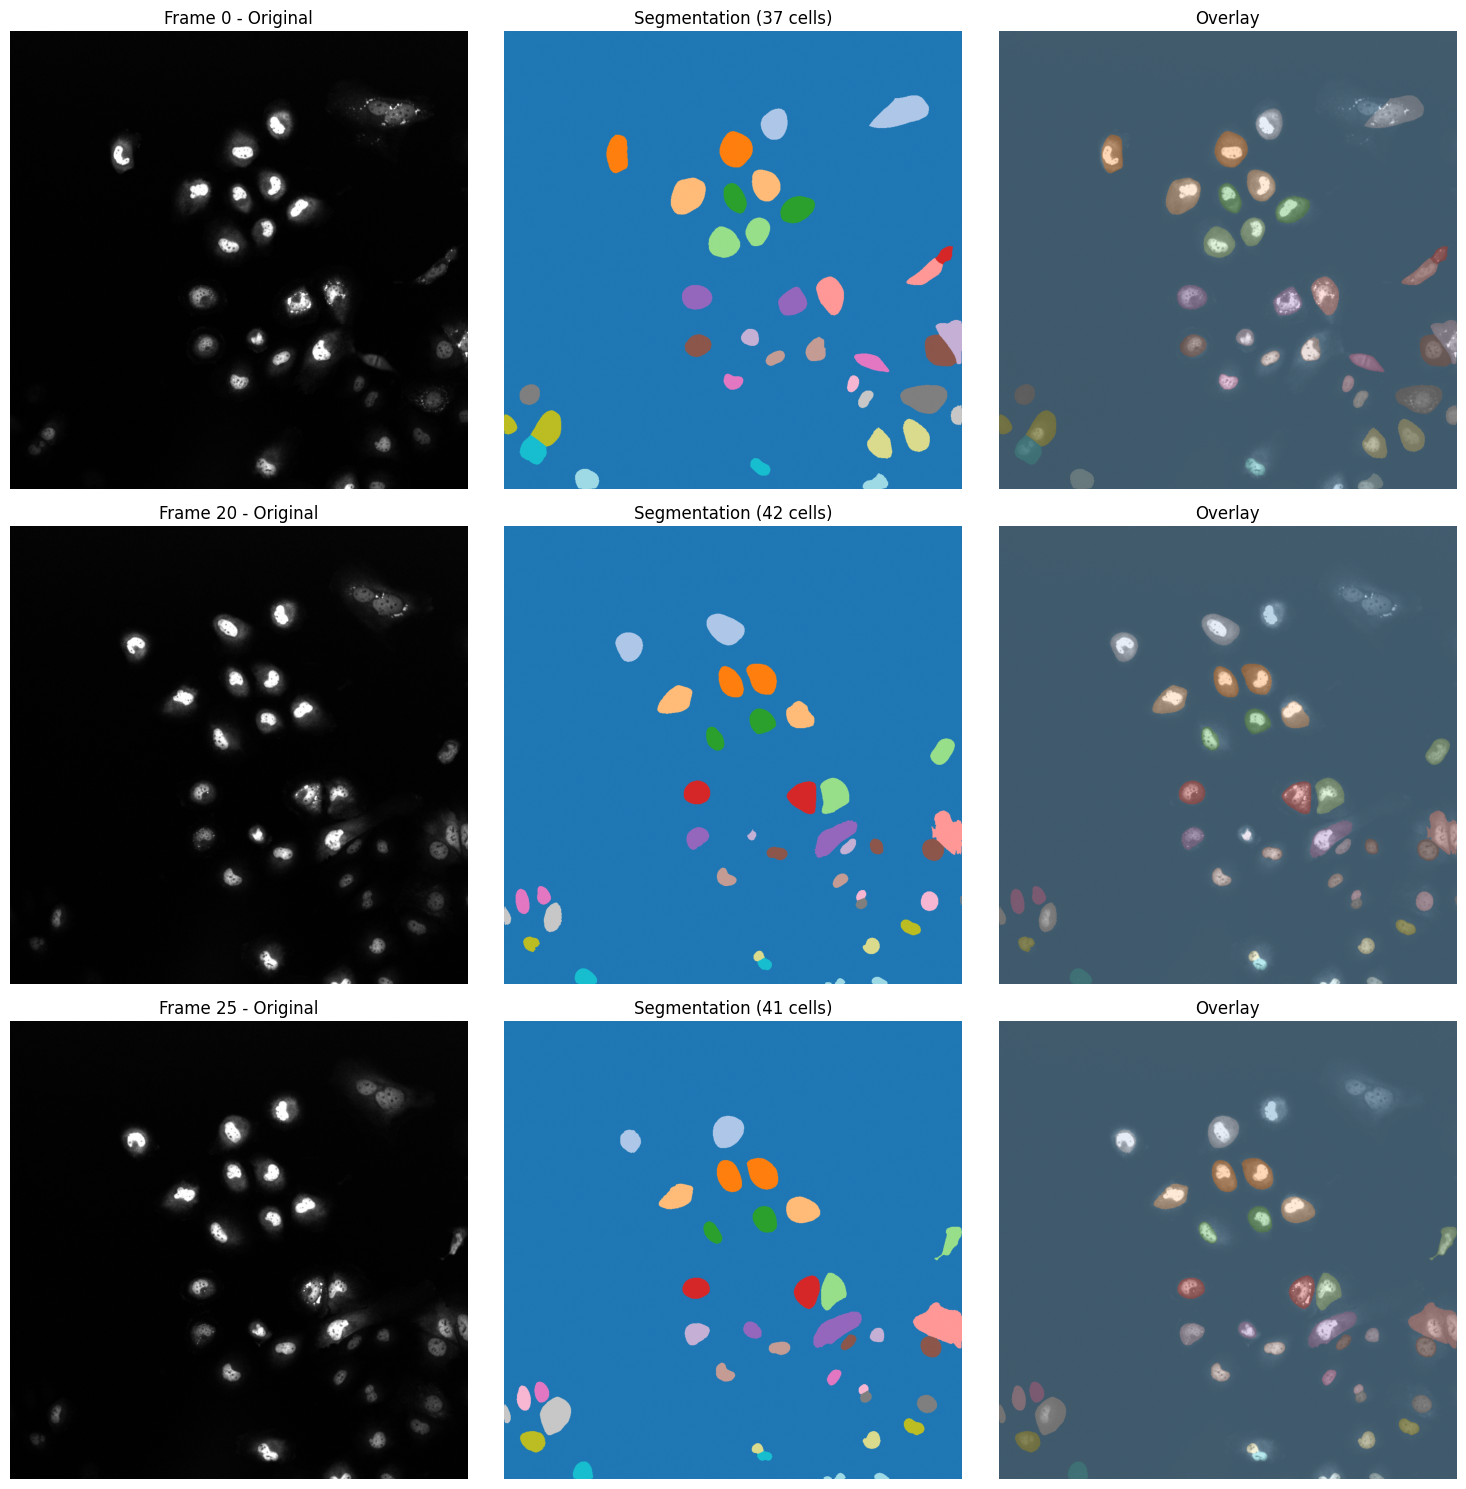

In [20]:
print("Initializing Cellpose CNN model...")
model = models.CellposeModel(gpu=True, model_type='nuclei')

# Segment all frames
print(f"Segmenting {len(frames)} frames with Cellpose CNN...")
all_masks = []

for i, frame in enumerate(frames):
    if i % 10 == 0:
        print(f"Processing frame {i}/{len(frames)}...")

    masks, flows, styles = model.eval(frame, diameter=30, channels=[0,0])
    all_masks.append(masks)

all_masks = np.array(all_masks)
print("\nSegmentation complete!")
print(f"Masks shape: {all_masks.shape}")


frames_to_show = [0, 20, 25]   # 3 frames → each row
fig, axes = plt.subplots(len(frames_to_show), 3, figsize=(15, 15))

for idx, frame_num in enumerate(frames_to_show):

    # --- Original ---
    axes[idx, 0].imshow(frames[frame_num], cmap='gray')
    axes[idx, 0].set_title(f"Frame {frame_num} - Original")
    axes[idx, 0].axis('off')

    # --- Segmentation ---
    axes[idx, 1].imshow(all_masks[frame_num], cmap='tab20')
    axes[idx, 1].set_title(f"Segmentation ({all_masks[frame_num].max()} cells)")
    axes[idx, 1].axis('off')

    # --- Overlay ---
    axes[idx, 2].imshow(frames[frame_num], cmap='gray', alpha=0.7)
    axes[idx, 2].imshow(all_masks[frame_num], cmap='tab20', alpha=0.3)
    axes[idx, 2].set_title("Overlay")
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()


In [11]:
!pip install trackpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for trackpy: filename=trackpy-0.7-py3-none-any.whl size=130480 sha256=efb7db4a18ef3145f377f8f865742f8eb9a89848432ccc86d18c626535d5bd95
  Stored in directory: /root/.cache/pip/wheels/35/97/08/ded65bf12054e510a946f888e0bbaf9d698e449eb365791b94
Successfully built trackpy


In [21]:
import trackpy as tp
import pandas as pd
from skimage.measure import regionprops

print("Extracting cell centroids and properties...")

all_tracks = []

for frame_num, mask in enumerate(all_masks):
    props = regionprops(mask)

    for prop in props:
        all_tracks.append({
            'frame': frame_num,
            'y': float(prop.centroid[0]),
            'x': float(prop.centroid[1]),
            'cell_id': int(prop.label),
            'area': int(prop.area)
        })

tracks_df = pd.DataFrame(all_tracks)

print(f"Total detections: {len(tracks_df)}")
print(f"Frames detected: {tracks_df['frame'].nunique()}")
print("\nExample detections:")
print(tracks_df.head())


print("\nLinking cells across frames to create tracks...")

tracks = tp.link_df(
    tracks_df,
    search_range=12,
    memory=2,
    pos_columns=['x', 'y']
)


tracks["particle"] = tracks["particle"].astype(int)


print("\nTracking complete!")
print(f"Total unique tracks: {tracks['particle'].nunique()}")
print(f"Average track length: {len(tracks) / tracks['particle'].nunique():.1f} frames")

# Track length statistics
track_lengths = tracks.groupby('particle').size()

print("\nTrack length statistics:")
print(f"  Shortest track: {track_lengths.min()} frames")
print(f"  Longest track: {track_lengths.max()} frames")
print(f"  Median track: {track_lengths.median():.0f} frames")

# Filter long tracks
min_track_length = 10
long_tracks = tracks.groupby('particle').filter(lambda x: len(x) >= min_track_length)

print(f"\nTracks lasting at least {min_track_length} frames: {long_tracks['particle'].nunique()}")


Frame 29: 42 trajectories present.

Tracking complete!
Total unique tracks: 87
Average track length: 13.3 frames

Track length statistics:
  Shortest track: 1 frames
  Longest track: 30 frames
  Median track: 10 frames

Tracks lasting at least 10 frames: 44


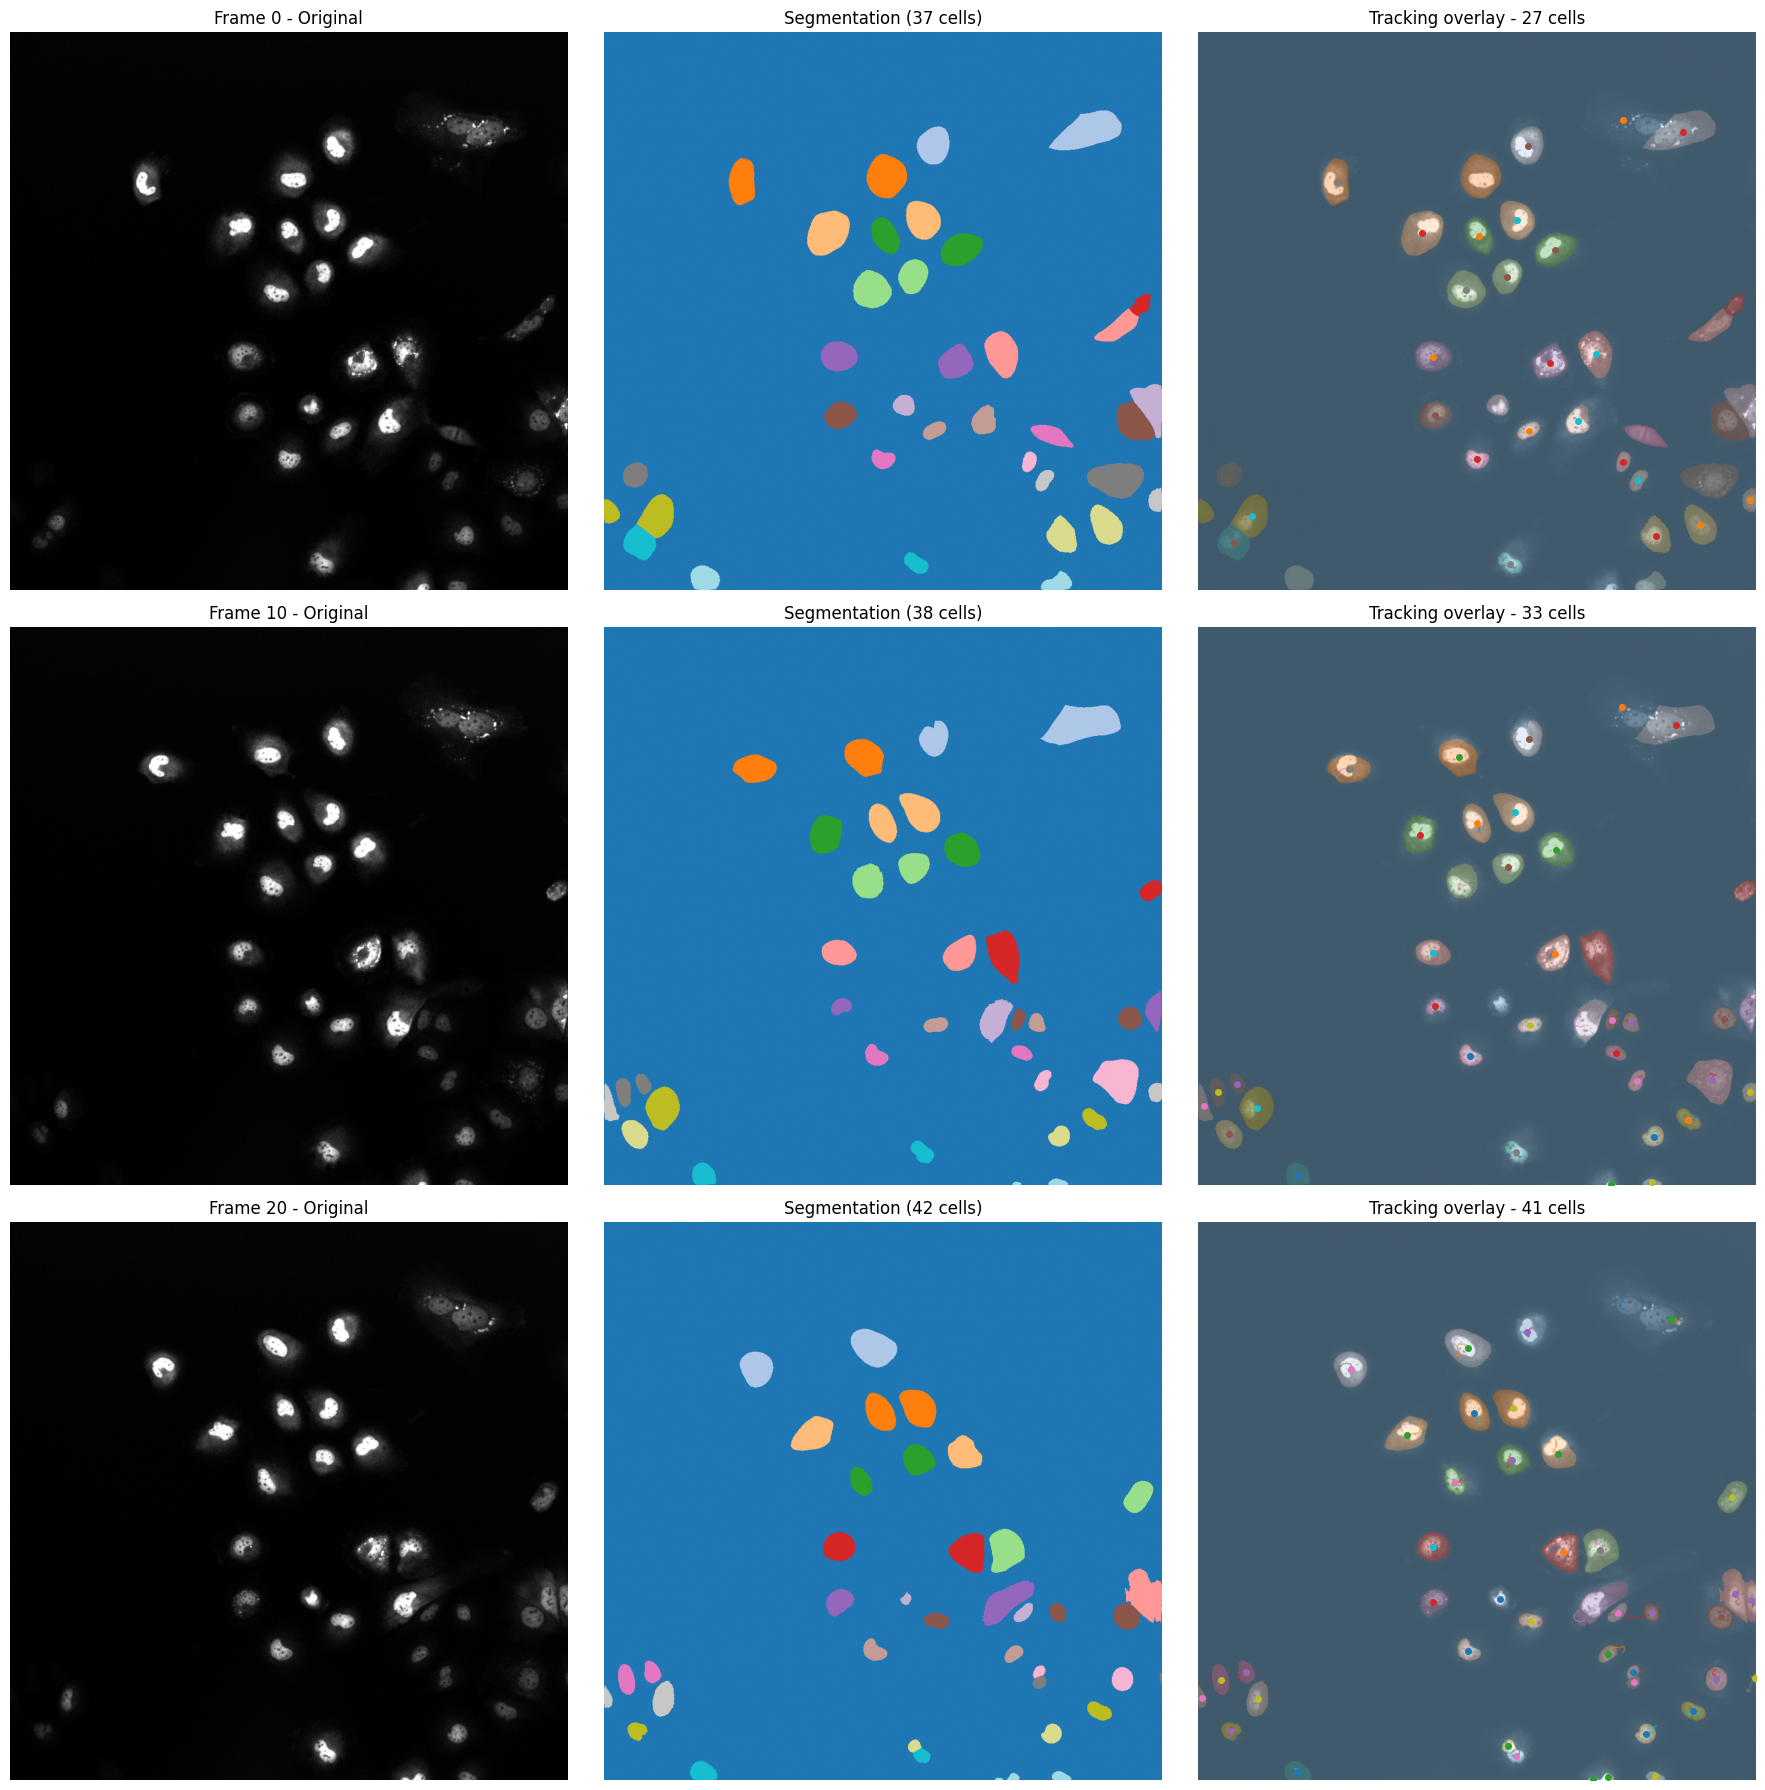

In [23]:
import matplotlib.pyplot as plt


num_rows = len(frames_to_show)
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 6*num_rows))

if num_rows == 1:
    axes = axes.reshape(1,3)  # pour uniformiser la structure

for idx, frame_num in enumerate(frames_to_show):
    ax_orig, ax_seg, ax_track = axes[idx]


    ax_orig.imshow(frames[frame_num], cmap='gray')
    ax_orig.set_title(f'Frame {frame_num} - Original')
    ax_orig.axis('off')

    ax_seg.imshow(all_masks[frame_num], cmap='tab20')
    ax_seg.set_title(f'Segmentation ({all_masks[frame_num].max()} cells)')
    ax_seg.axis('off')


    ax_track.imshow(frames[frame_num], cmap='gray', alpha=0.7)
    ax_track.imshow(all_masks[frame_num], cmap='tab20', alpha=0.3)

    # Tracks up to this frame
    tracks_until_now = long_tracks[long_tracks['frame'] <= frame_num]
    for particle_id in tracks_until_now['particle'].unique():
        particle_track = tracks_until_now[tracks_until_now['particle'] == particle_id]
        ax_track.plot(particle_track['x'], particle_track['y'], linewidth=1, alpha=0.5)
        # Mark current position
        current = particle_track[particle_track['frame'] == frame_num]
        if len(current) > 0:
            ax_track.plot(current['x'], current['y'], 'o', markersize=4)

    ax_track.set_title(f'Tracking overlay - {len(tracks_until_now[tracks_until_now["frame"]==frame_num])} cells')
    ax_track.axis('off')

plt.tight_layout()
plt.show()


plt.show()
